# Simulate Vasicek Portfolio using PyMC <br>
By Prabhakar Srivastava

In [1]:
import numpy as np
from numpy.random import default_rng
import pymc as pm
from scipy import stats
import matplotlib.pyplot as plt
import arviz as az
import preliz as pz
import pytensor
import pytensor.tensor as pt

Random Seed and plotting style

In [2]:
random_state = sum(map(ord, "Vasicek"))

az.style.use("arviz-doc")

Vasicek Distribution <br>

<center> Let $P(X_i < c) = p $ <br>
<center> $p$ is the Probability of Default (PD) </center>
<center> Where $X_i \sim N(0,1)$ </center>
<center> $\Phi(c) = p$</center>
<center> $c = \Phi^{-1}(p)$ </center>

<center> $X_i$ can be decomposed into a sum of two independent Normals as follows
<center> $X_i = \sqrt{1-\rho}B_i + \sqrt{\rho}Z$
<center> $B_i$ and $Z$ are independent Standard Normals $N(0,1)$</center>
<center> $B_i$ is specific to entity $i$ and $Z$ is a systematic risk factor</center>

<center> $P(X_i < c) = P(\sqrt{1-\rho}B_i + \sqrt{\rho}Z < c)$
<center> $P(X_i < c) = P(B_i < \frac{\Phi^{-1}(p)-\sqrt{\rho}Z}{\sqrt{1-\rho}})$ </center>

<center> $P(X_i < c) = \Phi(\frac{\Phi^{-1}(p)-\sqrt{\rho}Z}{\sqrt{1-\rho}})$ </center>

Simulating the Vasicek with PyMC

In [3]:
PDsim = 0.25
ρsim = 0.15
N_pts = 1_000

In [4]:
def simulate_vasicek(PD:float = PDsim, 
                     ρ:float = ρsim, 
                     N_pts:int=N_pts, 
                     random_state:int=random_state) -> np.ndarray:
    '''
    Simulate from a Vasicek Default Detribution

    Args:
        PD: Probability of Default
        ρ: Correlation
        N_pts: Number of borrowers
        random_state: Random seed for simulation

    Returns:
        np.ndarray
    '''
    random_seed = default_rng(random_state)
    Z = stats.norm(loc=0., scale=1.).rvs(size=N_pts, random_state=random_seed)
    prob = stats.norm.cdf((stats.norm.ppf(PD) - np.sqrt(ρ)*Z)/np.sqrt(1-ρ))
    n_defaults = stats.binom.rvs(n=N_pts, p=prob, random_state=random_seed)
    default_rate = n_defaults/N_pts
    return default_rate

In [5]:
default_rates = simulate_vasicek(PD=PDsim, ρ=ρsim)

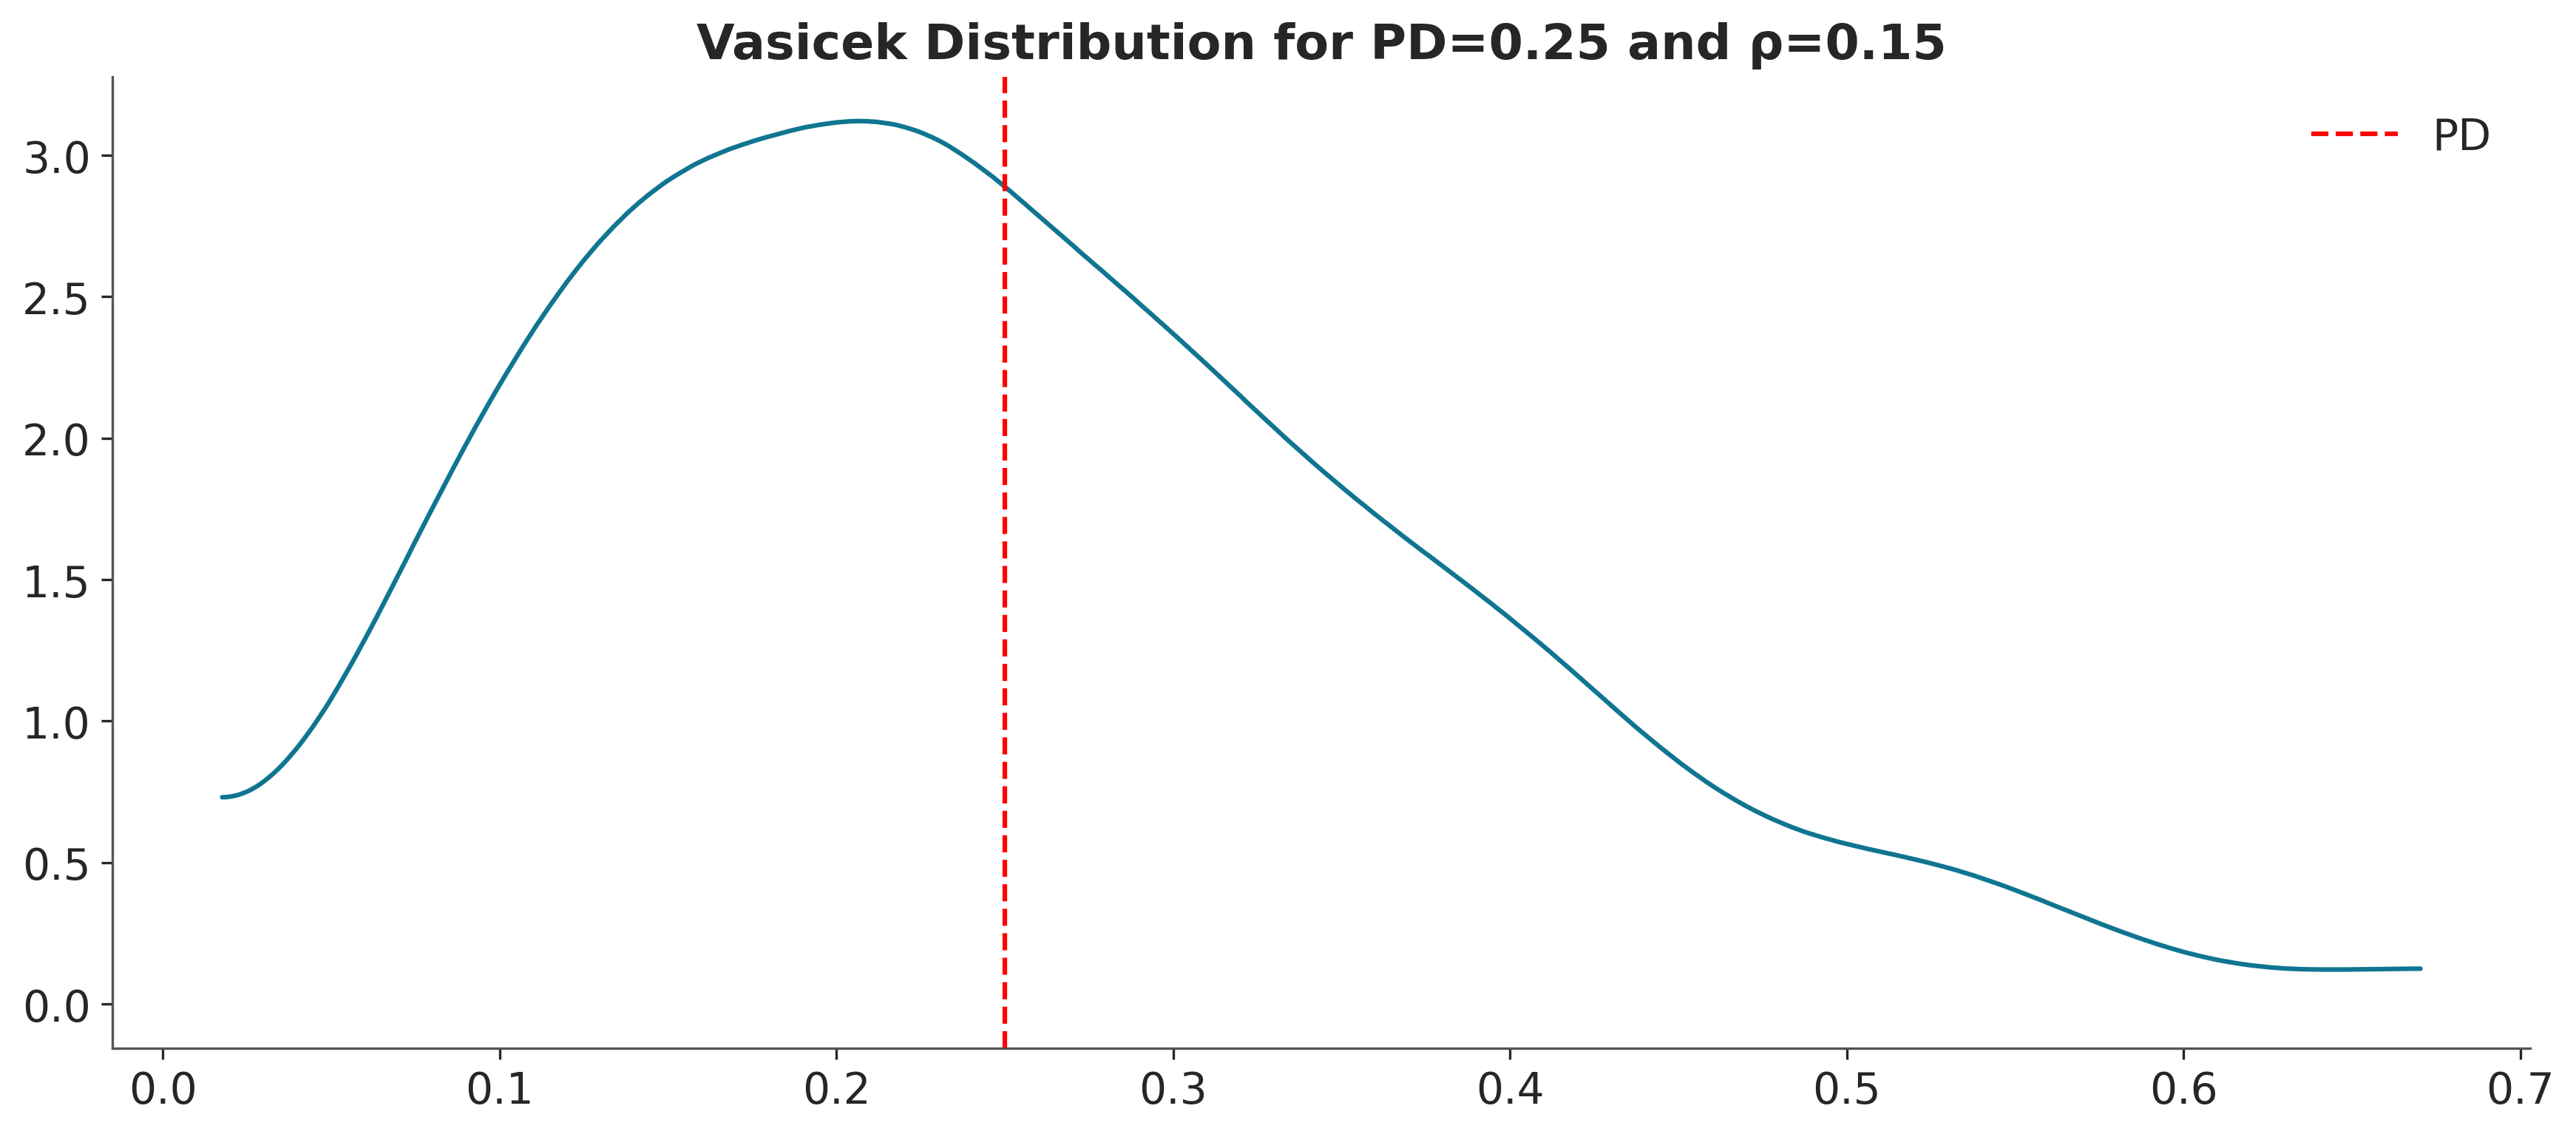

In [6]:
fig, ax = plt.subplots()
az.plot_kde(default_rates, ax=ax)
ax.set_title(f"Vasicek Distribution for PD={PDsim} and ρ={ρsim}")
ax.axvline(PDsim, color="red", ls="--", label="PD")
ax.legend()
plt.show()

Begin PyMC Model

In [7]:
def vasicek_logp(y, PD, rho):
    '''
    log density for the vasicek distribution

    Args:
        y: observed
        PD: Probability of Default
        rho: correlation
    '''

    sqrt = pm.math.sqrt
    phi = lambda z: pm.math.exp(-0.5*z**2)/sqrt(2*np.pi)

    num = phi((sqrt(1 - rho)*pm.math.probit(y) - pm.math.probit(PD))/sqrt(rho))
    den = phi(pm.math.probit(y))

    logp = pm.math.log(sqrt(1-rho)) + pm.math.log(num) - pm.math.log(sqrt(rho)) - pm.math.log(den)

    return logp
    

<Axes: >

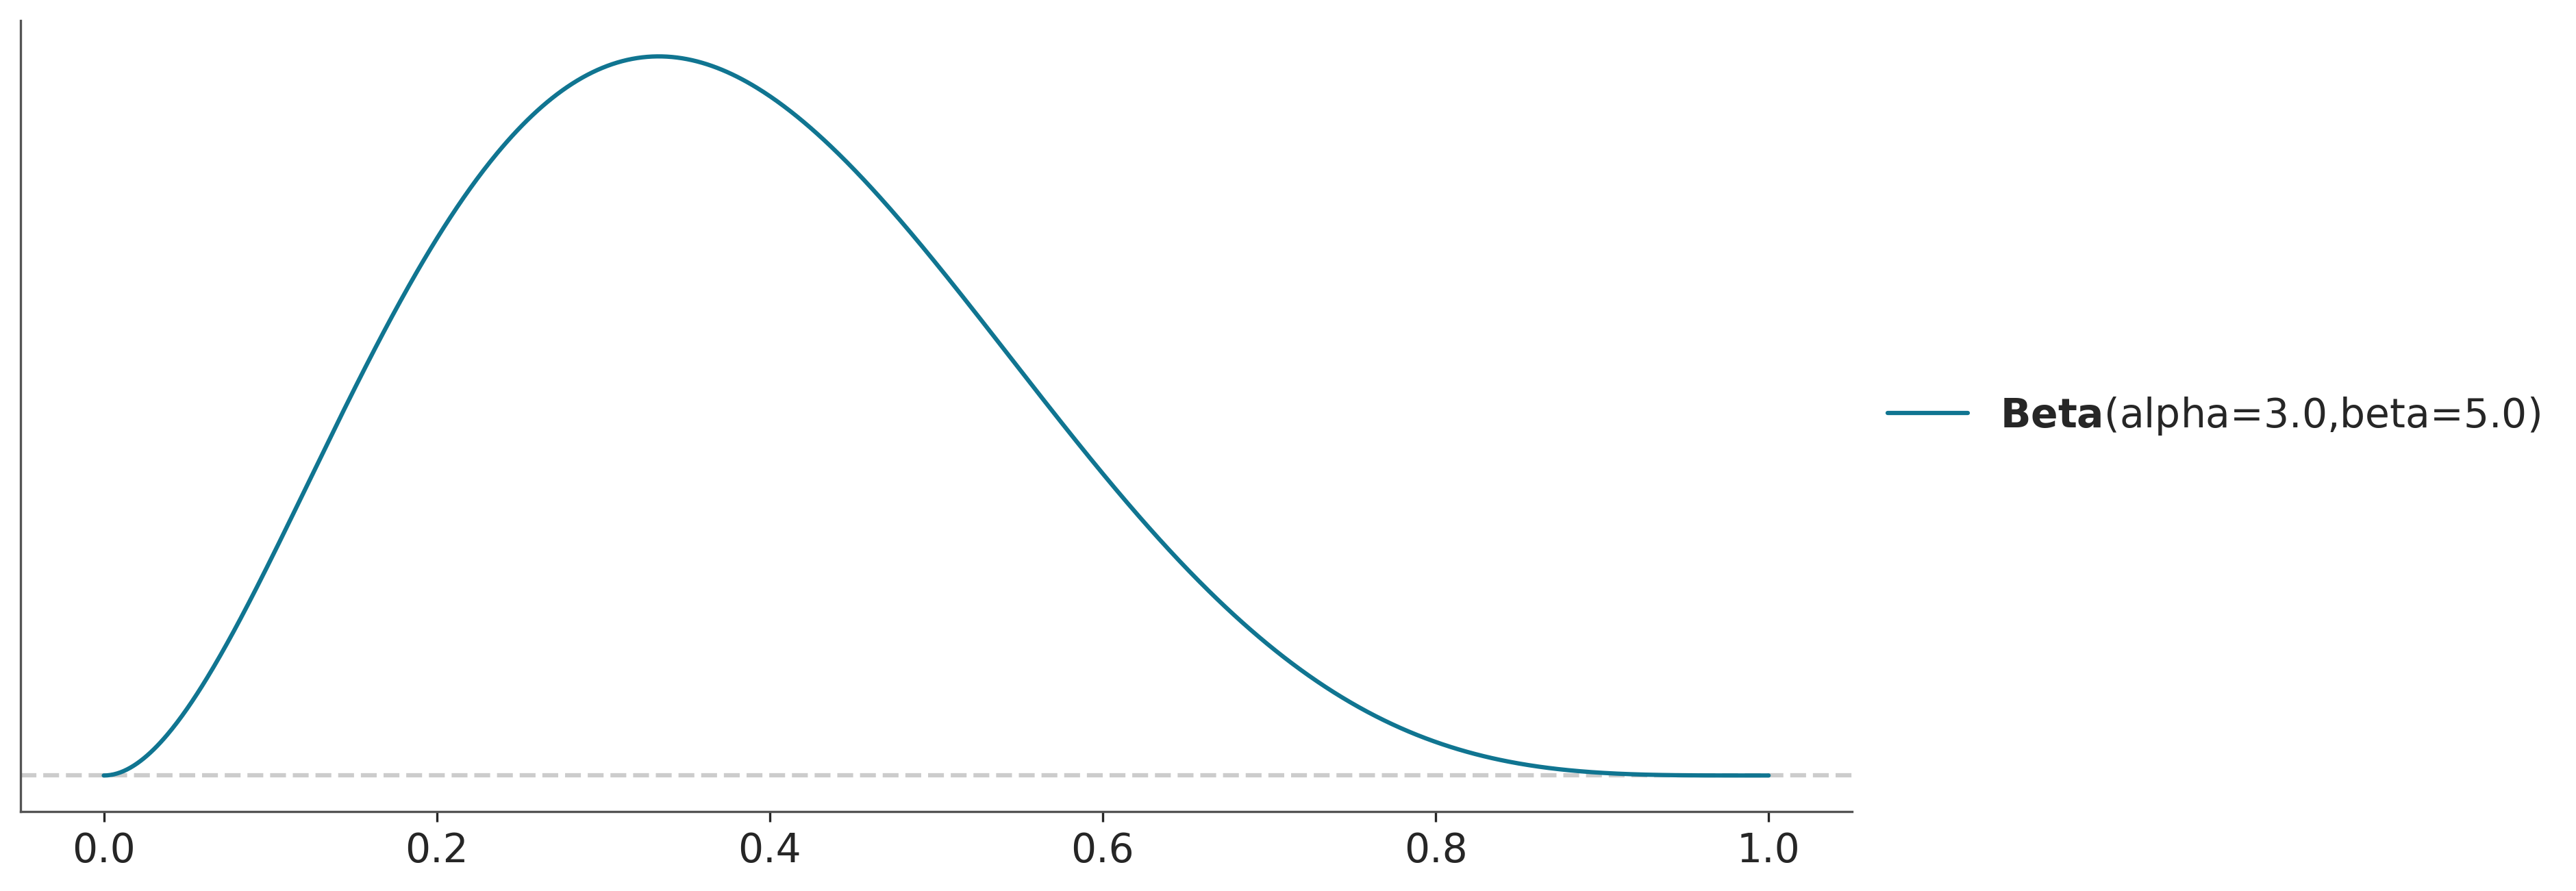

In [8]:
pz.Beta(3,5).plot_pdf()

In [9]:
# Testing the vasicek distribution
pytensor.config.cxx = '/Library/Developer/CommandLineTools/usr/bin/clang++'

COORDS = {"obs" : np.arange(len(default_rates))}
random_seed = default_rng(random_state)

with pm.Model(coords=COORDS) as vasicek_model:
    
    # Data variables
    dr = pm.Data("dr", default_rates)
    
    # Priors
    ρ = pm.Uniform("ρ", lower=-1, upper=1)
    PD = pm.Beta("PD", alpha=3., beta=5.)
    
    # Likelihood
    likelihood = pm.CustomDist("likelihood", PD, ρ, logp=vasicek_logp, observed=dr)

    idata_vasicek = pm.sample(random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ρ, PD]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [10]:
az.summary(idata_vasicek, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ρ,0.16,0.01,0.14,0.17,0.0,0.0,3912.91,2982.82,1.0
PD,0.25,0.00,0.24,0.26,0.0,0.0,3753.39,2768.05,1.0


Trace Plot

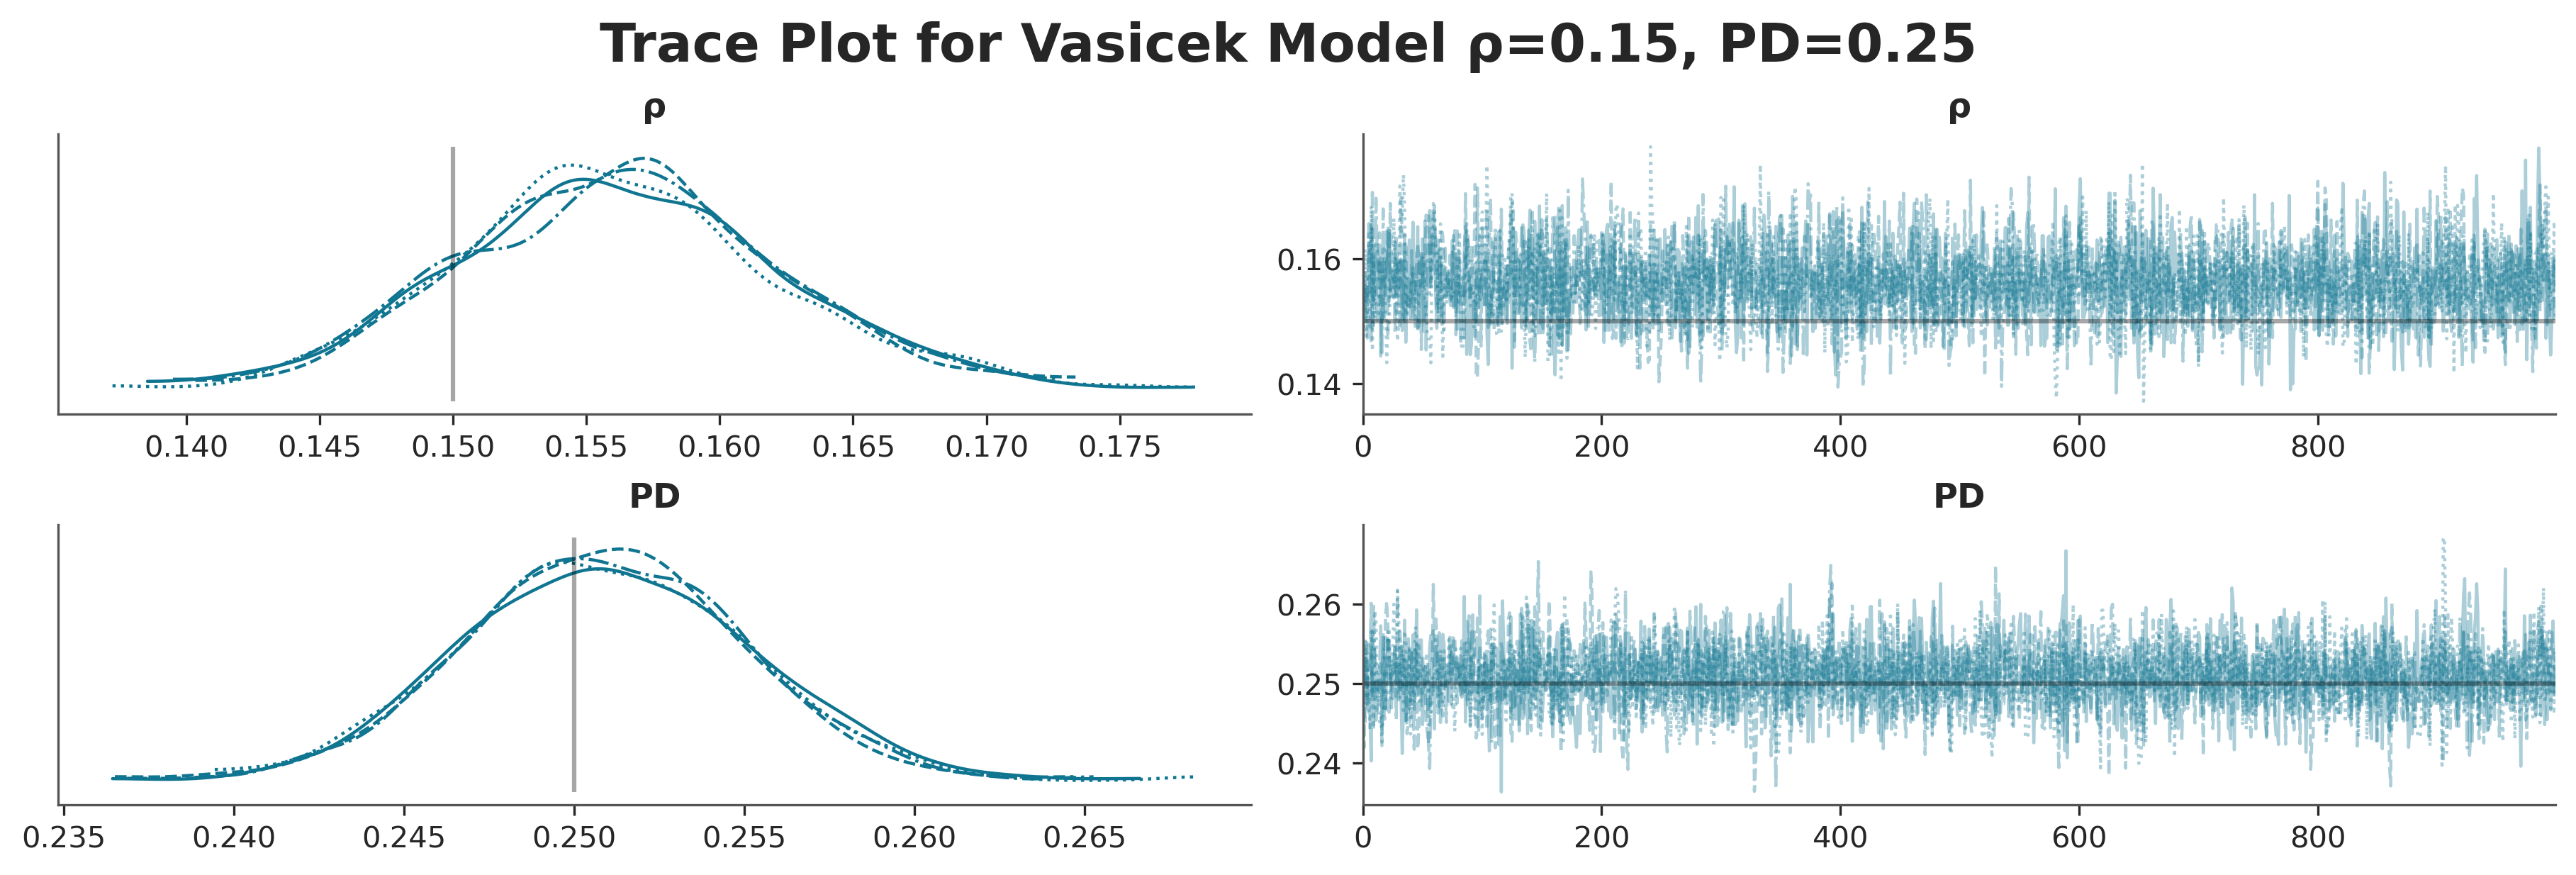

In [11]:
az.plot_trace(idata_vasicek,
             lines = [
                 ("ρ", {}, ρsim),
                 ("PD", {}, PDsim)
             ],
)
plt.suptitle(f"Trace Plot for Vasicek Model ρ={ρsim}, PD={PDsim}")
plt.show()

Posterior Predictive

In [12]:
#with vasicek_model:
#    idata_vasicek.extend(
#        pm.sample_posterior_predictive(
#            idata_vasicek,
#            random_seed=random_seed
#    )
#)